# Transfer Learning for Time Series Forecasting with Darts
Authors: Julien Herzen, Florian Ravasi, Guillaume Raille, Gaël Grosch.

## Overview
The goal of this notebook is to explore transfer learning for time series forecasting -- that is, training forecasting models on one time series dataset and using it on another. The notebook is 100% self-contained -- i.e., it also contains the necessary commands to install dependencies and download the datasets being used.

Depending on what constitutes a "learning task", what we call transfer learning here can also be seen under the angle of meta-learning (or "learning to learn"), where models can adapt themselves to new tasks (e.g. forecasting a new time series) at inference time without further training [1].

This notebook is an adaptation of a workshop on "Forecasting and Meta-Learning" that was given at the Applied Machine Learning Days conference in Lausanne, Switzerland, in March 2022.
It contains the following parts:

* **Part 0:** Initial setup - imports, functions to download data, etc.
* **Part 1:** Forecasting passenger counts series for 300 airlines (`air` dataset). We will train one model per series.
* **Part 2:** Using "global" models - i.e., models trained on all 300 series simultaneously.
* **Part 3:** We will try some transfer learning, and see what happens if we train some global models on one (big) dataset (`m4` dataset) and use them on another dataset.
* **Part 4:** We will reuse our pre-trained model(s) of Part 3 on another new dataset (`m3` dataset) and see how it compares to models specifically trained on this dataset.

The compute durations written for the different models have been obtained by running the notebook on a i9-10900K CPU, with an RTX 2080s GPU, with Python 3.9.7 and Darts 0.18.0.

## Part 0: Setup
First, we need to have the right libraries and make the right imports. For the deep learning models, it helps to have a GPU, but this is not mandatory.

The following two cells need to be run only once. They install the dependencies and download all the required datasets.

In [ ]:
!pip install darts==0.18.0 &> /dev/null
!pip install xarray==0.18.2 &> /dev/null  # required to read pickle files
!pip install xlrd==2.0.1 &> /dev/null

In [ ]:
# Execute this cell once to download all three datasets
# Some datasets are are in pickle for simplicity and speed.
!curl -L https://github.com/unit8co/amld2022-forecasting-and-metalearning/blob/main/data/m3_dataset.xls\?raw\=true -o m3_dataset.xls
!curl -L https://github.com/unit8co/amld2022-forecasting-and-metalearning/blob/main/data/passengers.pkl\?raw\=true -o passengers.pkl
!curl -L https://github.com/unit8co/amld2022-forecasting-and-metalearning/blob/main/data/m4_monthly_scaled.pkl\?raw\=true -o m4_monthly_scaled.pkl

And now we import everything. Don't be afraid, we will uncover what these imports mean through the notebook :)

In [1]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import *

We define the forecast horizon here - for all of the (monthly) time series used in this notebook, we'll be interested in forecasting 18 months in advance. We pick 18 months as this is what is used in the M3/M4 competitions for monthly series.

In [2]:
HORIZON = 18

### Datasets loading methods
Here, we define some helper methods to load the three datasets we'll be playing with: `air`, `m3` and `m4`. 

All the methods below return two list of `TimeSeries`: one list of training series and one list of "test" series (of length `HORIZON`).

For convenience, all the series are already scaled here, by multiplying each of them by a constant so that the largest value is 1. Such scaling is necessary for many models to work correctly (esp. deep learning models). It does not affect the sMAPE values, so we can evaluate the accuracy of our algorithms on the scaled series. In a real application, we would have to keep the Darts `Scaler` objects somewhere in order to inverse-scale the forecasts.

If you are interested in seeing an example of how creating and scaling `TimeSeries` is done, you can inspect the function `load_m3()`.

In [3]:
def load_m3() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    print("building M3 TimeSeries...")

    # Read DataFrame
    df_m3 = pd.read_excel("m3_dataset.xls", "M3Month")

    # Build TimeSeries
    m3_series = []
    for row in tqdm(df_m3.iterrows()):
        s = row[1]
        start_year = int(s["Starting Year"])
        start_month = int(s["Starting Month"])
        values_series = s[6:].dropna()
        if start_month == 0:
            continue

        start_date = datetime(year=start_year, month=start_month, day=1)
        time_axis = pd.date_range(start_date, periods=len(values_series), freq="M")
        series = TimeSeries.from_times_and_values(
            time_axis, values_series.values
        ).astype(np.float32)
        m3_series.append(series)

    print("\nThere are {} monthly series in the M3 dataset".format(len(m3_series)))

    # Split train/test
    print("splitting train/test...")
    m3_train = [s[:-HORIZON] for s in m3_series]
    m3_test = [s[-HORIZON:] for s in m3_series]

    # Scale so that the largest value is 1
    print("scaling...")
    scaler_m3 = Scaler(scaler=MaxAbsScaler())
    m3_train_scaled: List[TimeSeries] = scaler_m3.fit_transform(m3_train)
    m3_test_scaled: List[TimeSeries] = scaler_m3.transform(m3_test)

    print(
        "done. There are {} series, with average training length {}".format(
            len(m3_train_scaled), np.mean([len(s) for s in m3_train_scaled])
        )
    )
    return m3_train_scaled, m3_test_scaled


def load_air() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    # load TimeSeries
    print("loading air TimeSeries...")
    with open("passengers.pkl", "rb") as f:
        all_air_series = pickle.load(f)

    # Split train/test
    print("splitting train/test...")
    air_train = [s[:-HORIZON] for s in all_air_series]
    air_test = [s[-HORIZON:] for s in all_air_series]

    # Scale so that the largest value is 1
    print("scaling series...")
    scaler_air = Scaler(scaler=MaxAbsScaler())
    air_train_scaled: List[TimeSeries] = scaler_air.fit_transform(air_train)
    air_test_scaled: List[TimeSeries] = scaler_air.transform(air_test)

    print(
        "done. There are {} series, with average training length {}".format(
            len(air_train_scaled), np.mean([len(s) for s in air_train_scaled])
        )
    )
    return air_train_scaled, air_test_scaled


def load_m4() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    # load TimeSeries - the splitting and scaling has already been done
    print("loading M4 TimeSeries...")
    with open("m4_monthly_scaled.pkl", "rb") as f:
        m4_series = pickle.load(f)

    # filter and keep only series that contain at least 48 training points
    m4_series = list(filter(lambda t: len(t[0]) >= 48, m4_series))

    m4_train_scaled, m4_test_scaled = zip(*m4_series)

    print(
        "done. There are {} series, with average training length {}".format(
            len(m4_train_scaled), np.mean([len(s) for s in m4_train_scaled])
        )
    )
    return m4_train_scaled, m4_test_scaled

Finally, we define a handy function to tell us how good a bunch of forecasted series are:

In [4]:
def eval_forecasts(
    pred_series: List[TimeSeries], test_series: List[TimeSeries]
) -> List[float]:

    print("computing sMAPEs...")
    smapes = smape(test_series, pred_series)
    plt.figure()
    plt.hist(smapes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("Median sMAPE: %.3f" % np.median(smapes))
    plt.show()
    plt.close()
    return smapes

## Part 1: Local models on the `air` dataset

### Inspecting Data

The `air` dataset contains the number of air passengers that flew in or out of the USA per carrier (or airline company) from the year 2000 until 2019.

First, we can load the train and test series by calling `load_air()` function that we have defined above.

In [5]:
air_train, air_test = load_air()

loading air TimeSeries...
splitting train/test...
scaling series...
done. There are 301 series, with average training length 136.83388704318938


It's a good idea to start by visualising a few of the series to get a sense of what they look like. We can plot a series by calling `series.plot()`.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


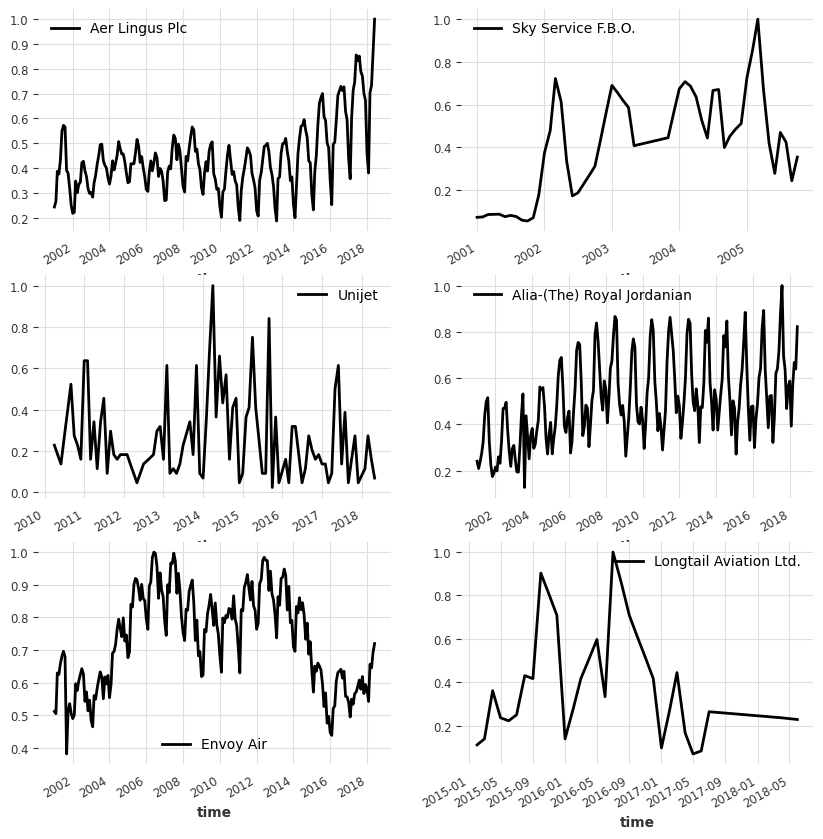

In [6]:
figure, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=100)

for i, idx in enumerate([1, 20, 50, 100, 250, 300]):
    axis = ax[i % 3, i % 2]
    air_train[idx].plot(ax=axis)
    axis.legend(air_train[idx].components)
    axis.set_title("");

We can see that most series look quite different, and they even have different time axes! For example some series start in Jan 2001 and others in April 2010.

Let's see what is the shortest train series available:

In [7]:
min([len(s) for s in air_train])

36

### A useful function to evaluate models

Below, we write a small function that will make our life easier for quickly trying and comparing different local models. We loop through each serie, fit a model and then evaluate on our test dataset. 

> ⚠️  `tqdm` is optional and is only there to help display the training progress (as you will see it can take some time when training 300+ time series)


In [8]:
def eval_local_model(
    train_series: List[TimeSeries], test_series: List[TimeSeries], model_cls, **kwargs
) -> Tuple[List[float], float]:
    preds = []
    start_time = time.time()
    for series in tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=HORIZON)
        preds.append(pred)
    elapsed_time = time.time() - start_time

    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

### Building and evaluating models

We can now try a first forecasting model on this dataset. As a first step, it is usually a good practice to see how a (very) naive model blindly repeating the last value of the training series performs. This can be done in Darts using a [NaiveSeasonal](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.baselines.html#darts.models.forecasting.baselines.NaiveSeasonal) model:

  0%|          | 0/301 [00:00<?, ?it/s]

computing sMAPEs...


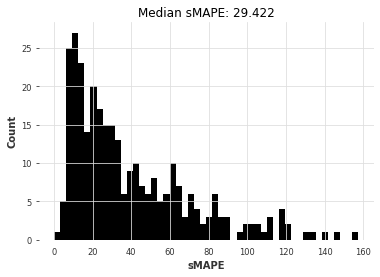

In [9]:
naive1_smapes, naive1_time = eval_local_model(air_train, air_test, NaiveSeasonal, K=1)

So the most naive model gives us a median sMAPE of about 29.4.

Can we do better with a "less naive" model exploiting the fact that most monthly series have a seasonality of 12?

  0%|          | 0/301 [00:00<?, ?it/s]

computing sMAPEs...


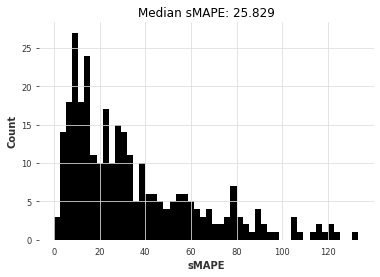

In [10]:
naive12_smapes, naive12_time = eval_local_model(
    air_train, air_test, NaiveSeasonal, K=12
)

This is better. Let's try ExponentialSmoothing (by default, for monthly series, it will use a seasonality of 12):

  0%|          | 0/301 [00:00<?, ?it/s]

computing sMAPEs...


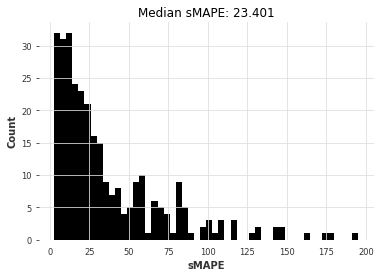

In [11]:
ets_smapes, ets_time = eval_local_model(air_train, air_test, ExponentialSmoothing)

The median is better for with the naive seasonal. Another model that we can quickly is the `Theta` method which has won the M3 competition:

  0%|          | 0/301 [00:00<?, ?it/s]

computing sMAPEs...


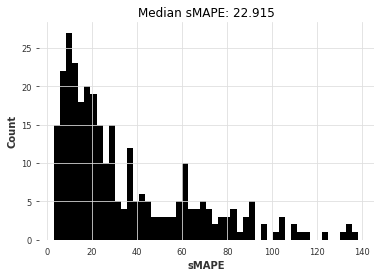

In [12]:
theta_smapes, theta_time = eval_local_model(air_train, air_test, Theta, theta=1.5)

And how about ARIMA?

  0%|          | 0/301 [00:00<?, ?it/s]

computing sMAPEs...


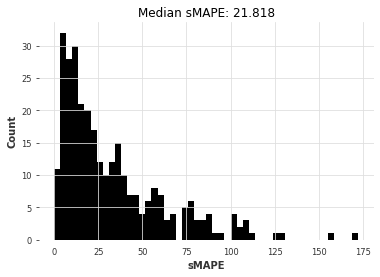

In [13]:
warnings.filterwarnings("ignore")  # ARIMA generates lots of warnings
arima_smapes, arima_time = eval_local_model(air_train, air_test, ARIMA, p=12, d=1, q=1)

Or the Kalman Filter? (in Darts, fitting Kalman filters uses the N4SID system identification algorithm)

  0%|          | 0/301 [00:00<?, ?it/s]

computing sMAPEs...


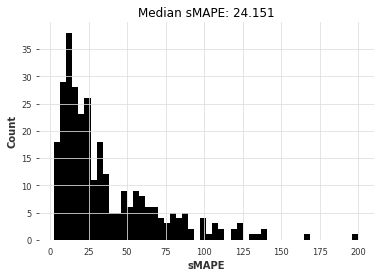

In [14]:
kf_smapes, kf_time = eval_local_model(air_train, air_test, KalmanForecaster, dim_x=12)

### Comparing models

Below, we define a function that will be useful to visualise how models compare to each other in terms of median sMAPE, and time required to obtain the forecasts.

In [15]:
def plot_models(method_to_elapsed_times, method_to_smapes):
    shapes = ["o", "s", "*"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    styles = list(product(shapes, colors))

    plt.figure(figsize=(6, 6), dpi=100)
    for i, method in enumerate(method_to_elapsed_times.keys()):
        t = method_to_elapsed_times[method]
        s = styles[i]
        plt.semilogx(
            [t],
            [np.median(method_to_smapes[method])],
            s[0],
            color=s[1],
            label=method,
            markersize=13,
        )
    plt.xlabel("elapsed time [s]")
    plt.ylabel("median sMAPE over all series")
    plt.legend(bbox_to_anchor=(1.4, 1.0), frameon=True);

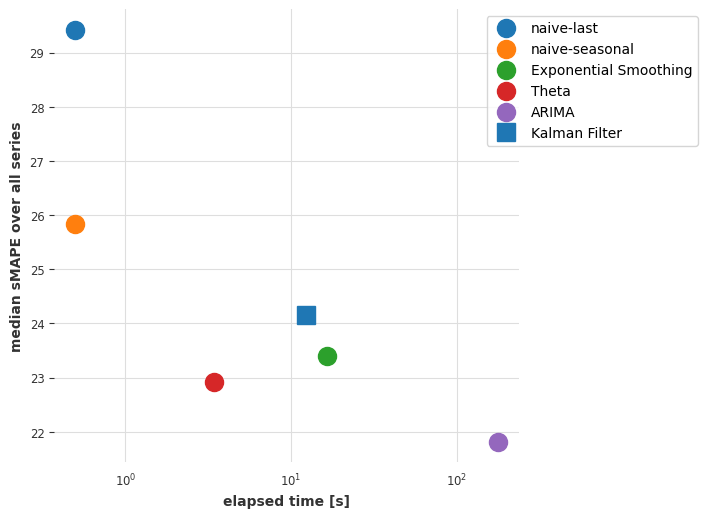

In [16]:
smapes = {
    "naive-last": naive1_smapes,
    "naive-seasonal": naive12_smapes,
    "Exponential Smoothing": ets_smapes,
    "Theta": theta_smapes,
    "ARIMA": arima_smapes,
    "Kalman Filter": kf_smapes,
}

elapsed_times = {
    "naive-last": naive1_time,
    "naive-seasonal": naive12_time,
    "Exponential Smoothing": ets_time,
    "Theta": theta_time,
    "ARIMA": arima_time,
    "Kalman Filter": kf_time,
}

plot_models(elapsed_times, smapes)

### Conclusions so far
ARIMA gives the best results, but it is also (by far) the most time-consuming model. The Theta method provides an interesting tradeoff, with good forecasting accuracy and about 50x faster than ARIMA. Can we maybe find a better compromise by considering *global* models - i.e., models that are trained only once, jointly on all time series?

## Part 2: Global models on the `air` dataset
In this section we will use "global models" - that is, models that are fit on multiple series at once. Darts has essentially two kinds of global models:

* `RegressionModels` which are wrappers around sklearn-like regression models (Part 2.1).
* PyTorch-based models, which offer various deep learning models (Part 2.2).

Both models can be trained on multiple series by "tabularizing" the data - i.e., taking many (input, output) sub-slices from all the training series, and training machine learning models in a supervised fashion to predict the output based on the input.

We start by defining a function `eval_global_model()` which works similarly to `eval_local_model()`, but on global models.

In [17]:
def eval_global_model(
    train_series: List[TimeSeries], test_series: List[TimeSeries], model_cls, **kwargs
) -> Tuple[List[float], float]:

    start_time = time.time()

    model = model_cls(**kwargs)
    model.fit(train_series)
    preds = model.predict(n=HORIZON, series=train_series)

    elapsed_time = time.time() - start_time

    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

### Part 2.1: Using Darts `RegressionModel`s.
`RegressionModel` in Darts are forecasting models that can wrap around any "scikit-learn compatible" regression model to obtain forecasts. Compared to deep learning, they represent good "go-to" global models because they typically don't have many hyper-parameters and can be faster to train. In addition, Darts also offers some "pre-packaged" regression models such as `LinearRegressionModel` and `LightGBMModel`.

We'll now use our function `eval_global_models()`. In the following cells, we will try using some regression models, for example:

* `LinearRegressionModel`
* `LightGBMModel`
* `RegressionModel(some_sklearn_model)`

You can refer to [the API doc](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) for how to use them.

Important parameters are `lags` and `output_chunk_length`. They determine respectively the length of the lookback and "lookforward" windows used by the model, and they correspond to the lengths of the input/output subslices used for training. For instance `lags=24` and `output_chunk_length=12` mean that the model will consume the past 24 lags in order to predict the next 12. In our case, because the shortest training series has length 36, we must have `lags + output_chunk_length <= 36`. (Note that `lags` can also be a list of integers representing the individual lags to be consumed by the model instead of the window length).

computing sMAPEs...


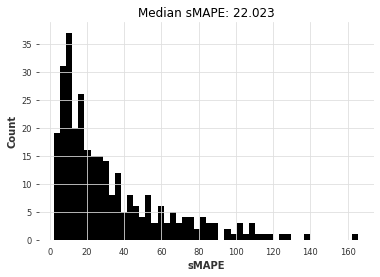

In [18]:
lr_smapes, lr_time = eval_global_model(
    air_train, air_test, LinearRegressionModel, lags=30, output_chunk_length=1
)

computing sMAPEs...


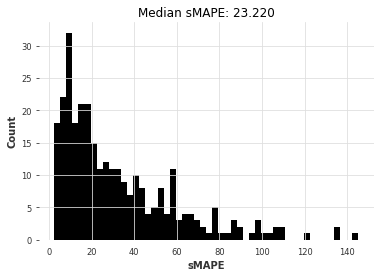

In [19]:
lgbm_smapes, lgbm_time = eval_global_model(
    air_train, air_test, LightGBMModel, lags=35, output_chunk_length=1, objective="mape"
)

computing sMAPEs...


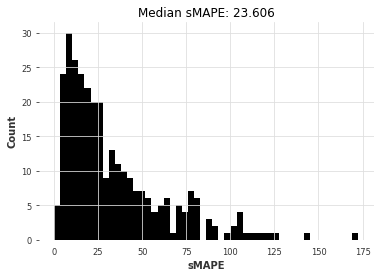

In [20]:
rf_smapes, rf_time = eval_global_model(
    air_train, air_test, RandomForest, lags=30, output_chunk_length=1
)

### Part 2.2: Using deep learning
Below, we will train an N-BEATS model on our `air` dataset. Again, you can refer to [the API doc](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html) for documentation on the hyper-parameters.
The following hyper-parameters should be a good starting point, and training should take in the order of a minute or two if you're using a (somewhat slow) Colab GPU.

During training, you can have a look at the [N-BEATS paper](https://arxiv.org/abs/1905.10437).

In [21]:
### Possible N-BEATS hyper-parameters

# Slicing hyper-params:
IN_LEN = 30
OUT_LEN = 4

# Architecture hyper-params:
NUM_STACKS = 20
NUM_BLOCKS = 1
NUM_LAYERS = 2
LAYER_WIDTH = 136
COEFFS_DIM = 11

# Training settings:
LR = 1e-3
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 10
NUM_EPOCHS = 10

Let's now build, train and predict using an N-BEATS model:

[2022-04-07 17:04:05,386] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 53277 samples.
[2022-04-07 17:04:05,386] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 53277 samples.
[2022-04-07 17:04:05,403] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-04-07 17:04:05,403] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | SmapeLoss  | 0     
1 | stacks    | ModuleList | 525 K 
-----------------------------------------
523 K     Trainable params
1.9 K     Non-trainable params
525 K     Total params
2.102     Total estimated model params size (MB

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 53it [00:00, ?it/s]

computing sMAPEs...


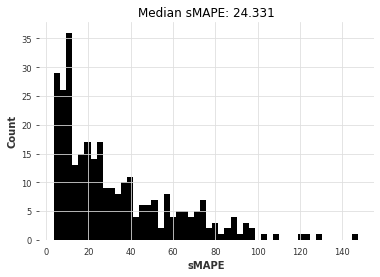

In [22]:
# reproducibility
np.random.seed(42)
torch.manual_seed(42)

start_time = time.time()

nbeats_model_air = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    loss_fn=SmapeLoss(),
    batch_size=BATCH_SIZE,
    optimizer_kwargs={"lr": LR},
    # remove this one if your notebook does run in a GPU environment:
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        "accelerator": "gpu",
        "gpus": -1,
        "auto_select_gpus": True,
    },
)

nbeats_model_air.fit(air_train, num_loader_workers=4, epochs=NUM_EPOCHS)

# get predictions
nb_preds = nbeats_model_air.predict(series=air_train, n=HORIZON)
nbeats_elapsed_time = time.time() - start_time

nbeats_smapes = eval_forecasts(nb_preds, air_test)

Let's now look again at our errors -vs- time plot:

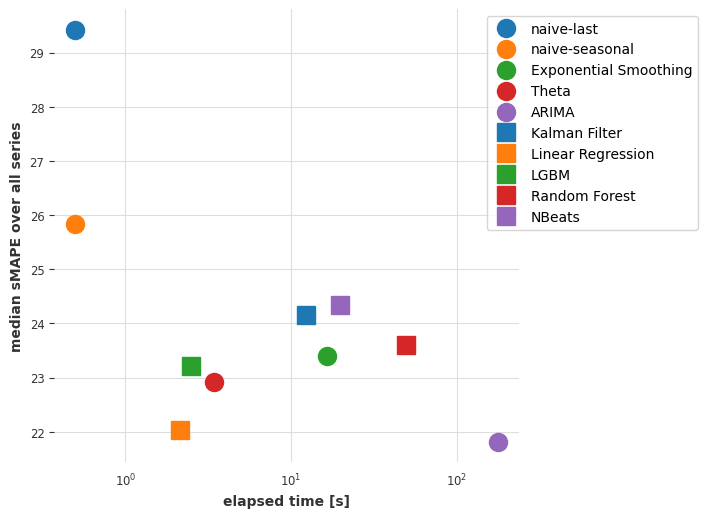

In [23]:
smapes_2 = {
    **smapes,
    **{
        "Linear Regression": lr_smapes,
        "LGBM": lgbm_smapes,
        "Random Forest": rf_smapes,
        "NBeats": nbeats_smapes,
    },
}

elapsed_times_2 = {
    **elapsed_times,
    **{
        "Linear Regression": lr_time,
        "LGBM": lgbm_time,
        "Random Forest": rf_time,
        "NBeats": nbeats_elapsed_time,
    },
}

plot_models(elapsed_times_2, smapes_2)

### Conclusions so far
So it looks like a linear regression model trained jointly on all series is now providing the best tradeoff between accuracy and speed (about 85x faster than ARIMA for similar accuracy). Linear regression is often the way to go!

Our deep learning model N-BEATS is not doing great. Note that we haven't tried to tune it to this problem explicitly, doing so might have produced more accurate results. Instead of spending time tuning it though, in the next part we will see if it can do better by being trained on an entirely different dataset.

## Part 3: Training an N-BEATS model on `m4` dataset and use it to forecast `air` dataset
Deep learning models often do better when trained on *large* datasets. Let's try to load all 48,000 monthly time series in the M4 dataset and train our model once more on this larger dataset.

In [24]:
m4_train, m4_test = load_m4()

loading M4 TimeSeries...
done. There are 47992 series, with average training length 216.32901316886148


We can start from the same hyper-parameters as before. 

With 48,000 M4 training series being on average ~200 time steps long, we would end up with ~10M training samples. With such a number of training samples, each epoch would take too long. So here, we'll limit the number of training samples used per series. This is done when calling `fit()` with the parameter `max_samples_per_ts`. We add a new hyper-parameter `MAX_SAMPLES_PER_TS` to capture this.

Since the M4 training series are all slightly longer, we can also use a slightly longer `input_chunk_length`.

In [25]:
# Slicing hyper-params:
IN_LEN = 36
OUT_LEN = 4

# Architecture hyper-params:
NUM_STACKS = 20
NUM_BLOCKS = 1
NUM_LAYERS = 2
LAYER_WIDTH = 136
COEFFS_DIM = 11

# Training settings:
LR = 1e-3
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = (
    10  # <-- new parameter, limiting the number of training samples per series
)
NUM_EPOCHS = 5

In [26]:
# reproducibility
np.random.seed(42)
torch.manual_seed(42)

nbeats_model_m4 = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    batch_size=BATCH_SIZE,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    loss_fn=SmapeLoss(),
    optimizer_kwargs={"lr": LR},
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        "accelerator": "gpu",
        "gpus": -1,
        "auto_select_gpus": True,
    },
)

# Train
nbeats_model_m4.fit(
    m4_train,
    num_loader_workers=4,
    epochs=NUM_EPOCHS,
    max_samples_per_ts=MAX_SAMPLES_PER_TS,
)

[2022-04-07 17:04:39,614] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 479920 samples.
[2022-04-07 17:04:39,614] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 479920 samples.
[2022-04-07 17:04:39,626] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-04-07 17:04:39,626] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | SmapeLoss  | 0     
1 | stacks    | ModuleList | 543 K 
-----------------------------------------
541 K     Trainable params
1.9 K     Non-trainable params
543 K     Total params
2.173     Total estimated model params size (

Training: 0it [00:00, ?it/s]

We can now use our M4-trained model to get forecasts for the air passengers series. As we use the model in a "meta learning" (or transfer learning) way here, we will be timing only the inference part.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 469it [00:00, ?it/s]

computing sMAPEs...


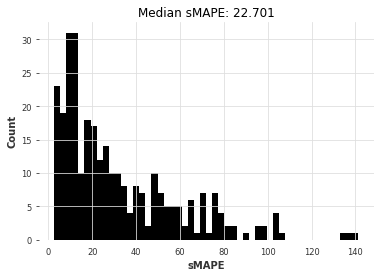

In [27]:
start_time = time.time()
preds = nbeats_model_m4.predict(series=air_train, n=HORIZON)  # get forecasts
nbeats_m4_elapsed_time = time.time() - start_time

nbeats_m4_smapes = eval_forecasts(preds, air_test)

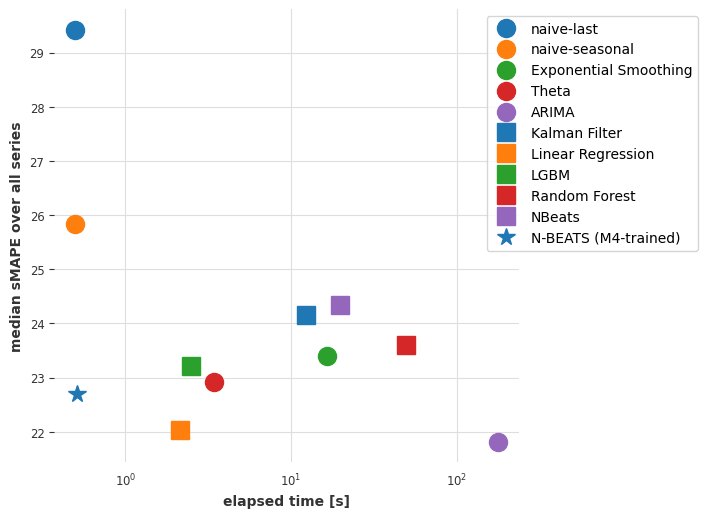

In [28]:
smapes_3 = {**smapes_2, **{"N-BEATS (M4-trained)": nbeats_m4_smapes}}

elapsed_times_3 = {
    **elapsed_times_2,
    **{"N-BEATS (M4-trained)": nbeats_m4_elapsed_time},
}

plot_models(elapsed_times_3, smapes_3)

### Conclusions so far
Although it's not the absolute best in terms of accuracy, our N-BEATS model trained on `m4` reaches competitive accuracies. This is quite remarkable because this model has *not* been trained on *any* of the `air` series we've asked it to forecast! The forecasting step with N-BEATS is ~350x faster than the fit-predict step we needed with ARIMA, and about 4x faster than the fit-predict step of linear regression.

Just for the fun, we can also inspect manually how this model does on another series -- for example, the monthly milk production series available in `darts.datasets`:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 469it [00:00, ?it/s]

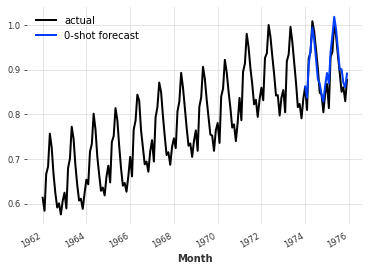

In [29]:
from darts.datasets import MonthlyMilkDataset

series = MonthlyMilkDataset().load().astype(np.float32)
train, val = series[:-24], series[-24:]

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
series = scaler.transform(series)
pred = nbeats_model_m4.predict(series=train, n=24)

series.plot(label="actual")
pred.plot(label="0-shot forecast")

### Try training other global models on `m4` and applying on airline passengers
Let's now try to train other global models on the M4 dataset in order to see if we can get similar results. Below, we will train some `RegressionModel`s on the full `m4` dataset. This can be quite slow. To have faster training we could use e.g., `random.choices(m4_train, k=5000)` instead of `m4_train` to limit the size of the training set. We could also specify some small enough value for `max_samples_per_ts` in order to limit the number of training samples.

computing sMAPEs...


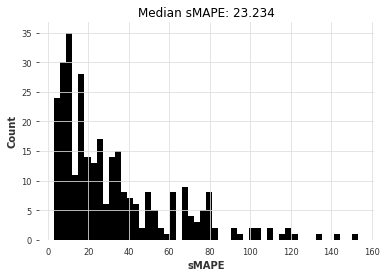

In [30]:
random.seed(42)

lr_model_m4 = LinearRegressionModel(lags=30, output_chunk_length=1)
lr_model_m4.fit(m4_train)

tic = time.time()
preds = lr_model_m4.predict(n=HORIZON, series=air_train)
lr_time_transfer = time.time() - tic

lr_smapes_transfer = eval_forecasts(preds, air_test)

computing sMAPEs...


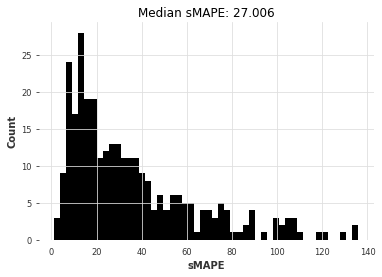

In [31]:
random.seed(42)

lgbm_model_m4 = LightGBMModel(lags=30, output_chunk_length=1, objective="mape")
lgbm_model_m4.fit(m4_train)

tic = time.time()
preds = lgbm_model_m4.predict(n=HORIZON, series=air_train)
lgbm_time_transfer = time.time() - tic

lgbm_smapes_transfer = eval_forecasts(preds, air_test)

Finally, let's plot these new results as well:

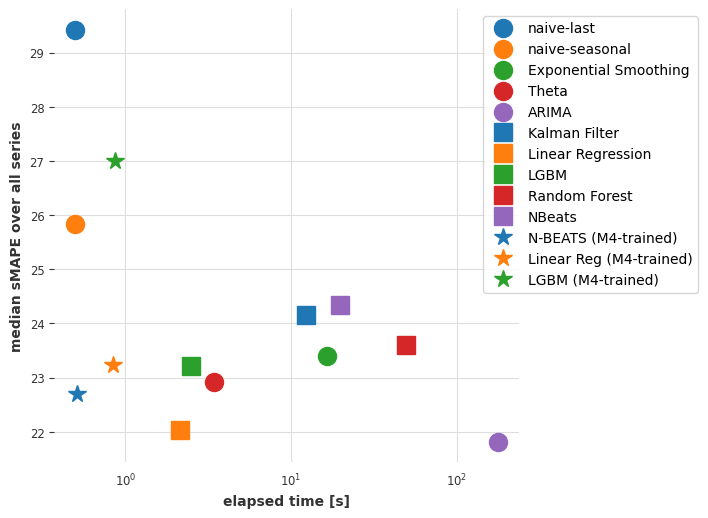

In [32]:
smapes_4 = {
    **smapes_3,
    **{
        "Linear Reg (M4-trained)": lr_smapes_transfer,
        "LGBM (M4-trained)": lgbm_smapes_transfer,
    },
}

elapsed_times_4 = {
    **elapsed_times_3,
    **{
        "Linear Reg (M4-trained)": lr_time_transfer,
        "LGBM (M4-trained)": lgbm_time_transfer,
    },
}

plot_models(elapsed_times_4, smapes_4)

Linear regression offers competitive performance too. It is somewhat slower probably only because the inference with N-BEATS is efficiently batched across batches of time series and performed on GPU. 

## Part 4 and recap: Use the same model on M3 dataset
OK, now, were we lucky with the airline passengers dataset? Let's see by repeating the entire process on a new dataset :) You will see that it actually requires very few lines of code. As a new dataset, we will use `m3`, which contains about 1,400 monthly series from the M3 competition.

In [33]:
m3_train, m3_test = load_m3()

building M3 TimeSeries...


0it [00:00, ?it/s]


There are 1399 monthly series in the M3 dataset
splitting train/test...
scaling...
done. There are 1399 series, with average training length 100.30092923516797


  0%|          | 0/1399 [00:00<?, ?it/s]

computing sMAPEs...


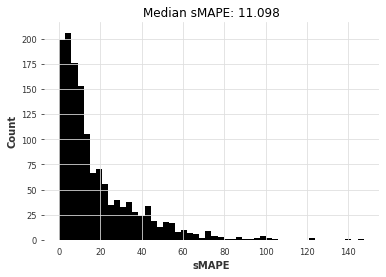

In [34]:
naive1_smapes_m3, naive1_time_m3 = eval_local_model(
    m3_train, m3_test, NaiveSeasonal, K=1
)

  0%|          | 0/1399 [00:00<?, ?it/s]

computing sMAPEs...


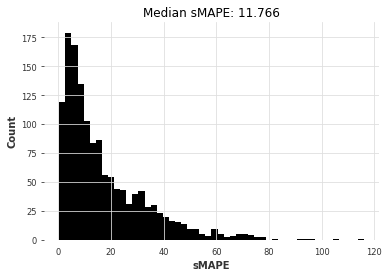

In [35]:
naive12_smapes_m3, naive12_time_m3 = eval_local_model(
    m3_train, m3_test, NaiveSeasonal, K=12
)

  0%|          | 0/1399 [00:00<?, ?it/s]

computing sMAPEs...


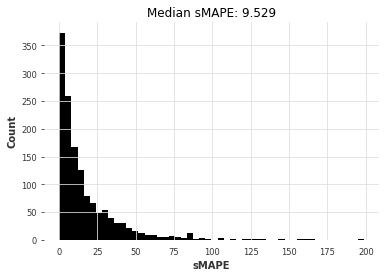

In [36]:
ets_smapes_m3, ets_time_m3 = eval_local_model(m3_train, m3_test, ExponentialSmoothing)

  0%|          | 0/1399 [00:00<?, ?it/s]

computing sMAPEs...


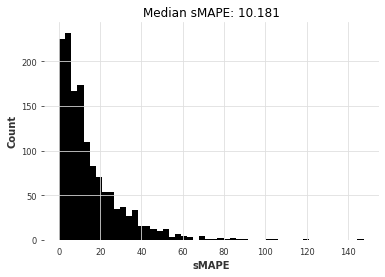

In [37]:
theta_smapes_m3, theta_time_m3 = eval_local_model(m3_train, m3_test, Theta)

  0%|          | 0/1399 [00:00<?, ?it/s]

computing sMAPEs...


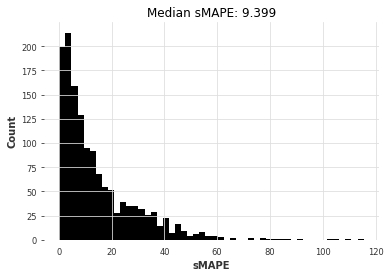

In [38]:
warnings.filterwarnings("ignore")  # ARIMA generates lots of warnings

# Note: using q=1 here generates errors for some series, so we use q=0
arima_smapes_m3, arima_time_m3 = eval_local_model(
    m3_train, m3_test, ARIMA, p=12, d=1, q=0
)

  0%|          | 0/1399 [00:00<?, ?it/s]

computing sMAPEs...


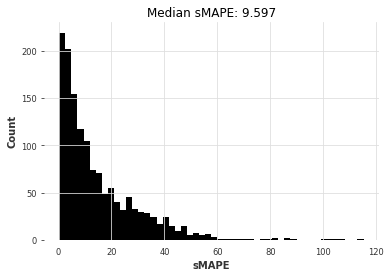

In [39]:
kf_smapes_m3, kf_time_m3 = eval_local_model(
    m3_train, m3_test, KalmanForecaster, dim_x=12
)

computing sMAPEs...


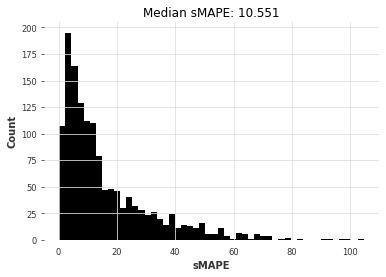

In [40]:
lr_smapes_m3, lr_time_m3 = eval_global_model(
    m3_train, m3_test, LinearRegressionModel, lags=30, output_chunk_length=1
)

computing sMAPEs...


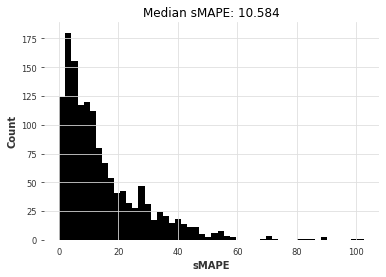

In [41]:
lgbm_smapes_m3, lgbm_time_m3 = eval_global_model(
    m3_train, m3_test, LightGBMModel, lags=35, output_chunk_length=1, objective="mape"
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 469it [00:00, ?it/s]

computing sMAPEs...


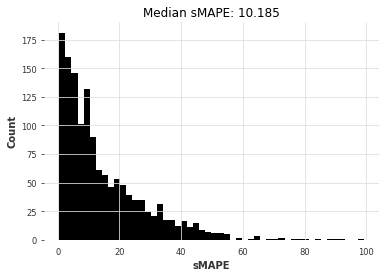

In [42]:
# Get forecasts with our pre-trained N-BEATS

start_time = time.time()
preds = nbeats_model_m4.predict(series=m3_train, n=HORIZON)  # get forecasts
nbeats_m4_elapsed_time_m3 = time.time() - start_time

nbeats_m4_smapes_m3 = eval_forecasts(preds, m3_test)

computing sMAPEs...


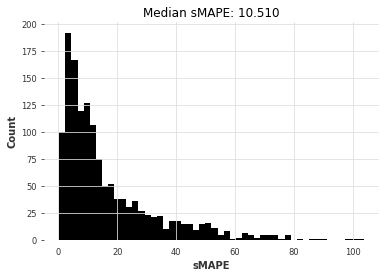

In [43]:
# Get forecasts with our pre-trained linear regression model

start_time = time.time()
preds = lr_model_m4.predict(series=m3_train, n=HORIZON)  # get forecasts
lr_m4_elapsed_time_m3 = time.time() - start_time

lr_m4_smapes_m3 = eval_forecasts(preds, m3_test)

computing sMAPEs...


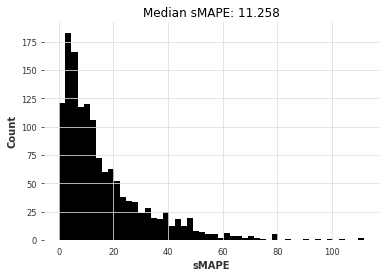

In [44]:
# Get forecasts with our pre-trained LightGBM model

start_time = time.time()
preds = lgbm_model_m4.predict(series=m3_train, n=HORIZON)  # get forecasts
lgbm_m4_elapsed_time_m3 = time.time() - start_time

lgbm_m4_smapes_m3 = eval_forecasts(preds, m3_test)

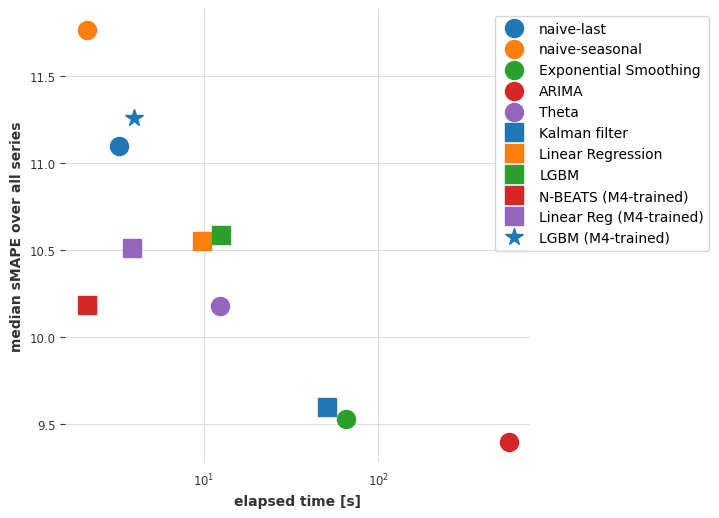

In [45]:
smapes_m3 = {
    "naive-last": naive1_smapes_m3,
    "naive-seasonal": naive12_smapes_m3,
    "Exponential Smoothing": ets_smapes_m3,
    "ARIMA": arima_smapes_m3,
    "Theta": theta_smapes_m3,
    "Kalman filter": kf_smapes_m3,
    "Linear Regression": lr_smapes_m3,
    "LGBM": lgbm_smapes_m3,
    "N-BEATS (M4-trained)": nbeats_m4_smapes_m3,
    "Linear Reg (M4-trained)": lr_m4_smapes_m3,
    "LGBM (M4-trained)": lgbm_m4_smapes_m3,
}

times_m3 = {
    "naive-last": naive1_time_m3,
    "naive-seasonal": naive12_time_m3,
    "Exponential Smoothing": ets_time_m3,
    "ARIMA": arima_time_m3,
    "Theta": theta_time_m3,
    "Kalman filter": kf_time_m3,
    "Linear Regression": lr_time_m3,
    "LGBM": lgbm_time_m3,
    "N-BEATS (M4-trained)": nbeats_m4_elapsed_time_m3,
    "Linear Reg (M4-trained)": lr_m4_elapsed_time_m3,
    "LGBM (M4-trained)": lgbm_m4_elapsed_time_m3,
}

plot_models(times_m3, smapes_m3)

Here too, the pre-trained N-BEATS model obtains reasonable accuracy, although not as good as the most accurate models. Note that two models out of the 3 most accurate (Exponential Smoothing and Kalman Filter) did not perform so well when used on the air passengers series. ARIMA performs best but is about 170x slower than N-BEATS, which didn't require any training and takes about 15 ms per time series to produce its forecasts. Recall that this N-BEATS model has *never* been trained on *any* of the series we're asking it to forecast.

## Conclusions
Transfer learning and meta learning is definitely an interesting phenomenon that is at the moment under-explored in time series forecasting. When does it succeed? When does it fail? Can fine tuning help? When should it be used? Many of these questions still have to be explored but we hope to have shown that doing so is quite easy with Darts models.

Now, which method is best for your case? As always, it depends. If you're dealing mostly with isolated series that have a sufficient history, classical methods such as ARIMA will get you a long way. Even on larger datasets, if compute power is not too much an issue, they can represent interesting out-of-the-box options. On the other hand if you're dealing with larger number of series, or series of higher dimensionalities, ML methods and global models will often be the way to go. They can capture patterns across wide ranges of different time series, and are in general faster to run. Don't under-estimate linear regression based models in this category! If you have reasons to believe you need to capture more complex patterns, or if inference speed is *really* important for you, give deep learning methods a shot. N-BEATS has proved its worth for meta-learning [1], but this can potentially work with other models too.

[1] Oreshkin et al., "Meta-learning framework with applications to zero-shot time-series forecasting", 2020, https://arxiv.org/abs/2002.02887